In [53]:
import sys
sys.path.append('/Users/reuben204/Reuben/Biomarker Finding/libexpr/algorithms')
import importlib

In [54]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter1d
from itertools import product
from tqdm import tqdm

In [55]:
from boruta import BorutaPy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, ParameterGrid
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, \
    precision_recall_curve, auc, average_precision_score
from sklearn.inspection import permutation_importance

In [56]:
import rutils as rt

In [57]:
importlib.reload(rt);

# Utility

In [58]:
def evaluateRFOOB(
    X, y, feature_index=None, params:dict=None, cv=10, 
    seed=None, metric=f1_score, use_proba=False,
    n_jobs=1, verbose=0
):
    rnd = np.random.default_rng(seed)
    seed_list = rnd.integers(0, 2**30, cv)

    param_dict = {} if params is None else params.copy()
    param_dict.update({'oob_score':True if use_proba else metric})

    if feature_index is None:
        X_subset = X
    else:
        X_subset = X[:, feature_index]
    
    score_array = np.zeros(cv)
    for i, s in enumerate(seed_list):
        rf_model = RandomForestClassifier(**param_dict, random_state=s, n_jobs=n_jobs)
        rf_model.fit(X_subset, y)
        
        if use_proba:
            y_pred_proba = rf_model.oob_decision_function_[:, 1]
            score_array[i] = metric(y, y_pred_proba)
        else:
            score_array[i] = rf_model.oob_score_
            
        if verbose==1:
            rt.iterLog(i)
    
    return score_array

# DATA LOADING

In [59]:
edata_df = pd.read_csv('../mutual-data/merged_edata.tsv', sep='\t', index_col=0)
mdata_df = pd.read_csv('../mutual-data/merged_mdata.tsv', sep='\t', index_col=0)
print( np.all(edata_df.columns == mdata_df.index) )

with open('../wgcna/common_genes.txt') as f:
	filter_genes = f.readlines()

gene_names = np.array([l for line in filter_genes if (l:=line.strip()) != ''])
print(f'{gene_names.size=}')

edata_df = edata_df.loc[gene_names,]
X = edata_df.T.to_numpy()
y = np.int_(mdata_df.condition == 'SC')

True
gene_names.size=101


In [60]:
# im = plt.imshow(np.corrcoef(X), cmap="coolwarm", interpolation="nearest")
# plt.colorbar(im)
Counter(y)

Counter({0: 33, 1: 14})

# BASIC RF

In [61]:
rf = RandomForestClassifier(
    n_estimators=400,
    class_weight='balanced',
    oob_score=f1_score,
    random_state=123
)
rf.fit(X, y)
rf.oob_score_

0.6086956521739131

In [62]:
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 5, None],
    'max_features': ['sqrt', 'log2', 0.2],
    'min_samples_split': [2, 3, 4],
    'class_weight' : ['balanced'],
    'criterion' : ['gini', 'entropy']
}
len(ParameterGrid(param_grid))

162

In [63]:
score_arr = []
param_bucket = []
best_score = 0
best_param = None
for i, param in enumerate(tqdm(
    ParameterGrid(param_grid), ncols=len(ParameterGrid(param_grid)), leave=True, dynamic_ncols=True
)):
    score = evaluateRFOOB(X, y, params=param, cv=80, seed=i, use_proba=True, metric=roc_auc_score, n_jobs=4)
    score_arr.append(score)
    param_bucket.append(param)

    if score.mean() > best_score:
        best_score = score.mean()
        best_param = param

score_arr = np.array(score_arr)

100%|██████████| 162/162 [1:01:06<00:00, 22.63s/it]


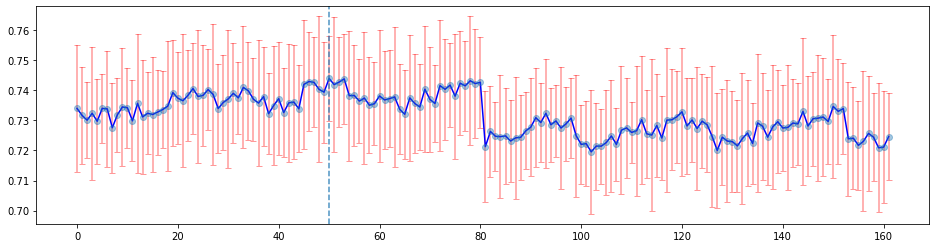

In [67]:
plt.figure(figsize=(16, 4))
# plt.axvline( X.shape[1]+1, ls='--', alpha=0.8)
plt.errorbar(
    x = range(162),
    y = score_arr.mean(1), yerr=score_arr.std(axis=1, ddof=1),
    fmt='o', ecolor='red', alpha=0.4, capsize=3
)
plt.plot(range(162), score_arr.mean(1), c='blue')
plt.axvline(50,ls='--', alpha=0.8)

In [66]:
passed_idx = score_arr.mean(1) > score_arr.mean(1).max() - score_arr.var(axis=1, ddof=0)
print(passed_idx)
print(np.where(passed_idx==1))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
(array([50, 5

In [80]:
print(best_score)
print(best_param)
print(score_arr[50].mean(), score_arr[53].mean())
param_bucket[50]

0.7439529220779221
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 0.2, 'min_samples_split': 3, 'n_estimators': 600}
0.7439529220779221 0.7438041125541126


{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 0.2,
 'min_samples_split': 3,
 'n_estimators': 600}

In [81]:
final_param = {'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 0.2,
 'min_samples_split': 3,
 'n_estimators': 600}

In [82]:
evaluateRFOOB(X, y, params=final_param, seed=12, use_proba=False, metric=f1_score).mean()

0.6013175230566535

# Boruta

In [84]:
rf_boruta = RandomForestClassifier(
    **final_param,
    n_jobs=4,
    random_state=726
)

In [85]:
n_bootstraps = 200
gene_selection_counts = np.zeros(X.shape[1])
gene_selection_rank = np.zeros((n_bootstraps, X.shape[1]))

rnd = rt.set_seed(37)
for i in tqdm(range(n_bootstraps)):
    X_boot, _, y_boot, _ = rt.bootstrap_resample(X, y, rnd_engine=rnd, oob=False)
     
    boruta = BorutaPy(
        estimator=rf_boruta,
        n_estimators="auto",
        alpha=0.1,
        max_iter=100,
        verbose=0
    )
    boruta.fit(X_boot, y_boot)
    selected_mask = boruta.support_
    gene_selection_counts += selected_mask.astype(int)
    gene_selection_rank[i, :] = boruta.ranking_.copy()

100%|██████████| 200/200 [35:57<00:00, 10.79s/it]


In [90]:
mean_rank = gene_selection_rank.mean(axis=0)
median_rank = np.median(gene_selection_rank, axis=0)
indices = np.argsort(median_rank)

In [91]:
gene_names[indices]

array(['YIPF2', 'PUF60', 'RBM10', 'HMG20B', 'SYMPK', 'HRAS', 'SMPD1',
       'DDX41', 'ZNF444', 'SYBU', 'NUMA1', 'GPAA1', 'CLTB', 'TXNRD1',
       'TXLNA', 'GCLC', 'ATP5F1D', 'ME1', 'EML3', 'GCLM', 'ASF1A', 'ETFB',
       'NCOR2', 'RFXANK', 'ALDH3A1', 'CDC14B', 'PIR', 'PRMT1', 'RAB1B',
       'SLC25A11', 'RALGAPA1P1', 'IFT25', 'MFSD10', 'CHPF2', 'POLR2E',
       'PRDX1', 'MICALL1', 'PRKCSH', 'ECH1', 'NKIRAS2', 'PLSCR3',
       'SLC7A11', 'BBLN', 'ARFGAP2', 'GBF1', 'LAMB2', 'PLXNB2', 'BAG6',
       'GPX2', 'HTATIP2', 'CTDNEP1', 'GPKOW', 'MAP2K2', 'GSS', 'EED',
       'UQCRC1', 'GTF2F1', 'PPP1CA', 'HYOU1', 'TAX1BP3', 'SUPT6H', 'GPC1',
       'SCAP', 'MGRN1', 'ZNF322', 'PRSS8', 'TMEM214', 'MPST', 'NQO1',
       'YIPF3', 'FGFR3', 'TMEM222', 'SNRPB', 'SEC61A1', 'AURKAIP1',
       'SND1', 'DAG1', 'TMEM109', 'GPS2', 'TM2D1', 'POLR2K', 'FARSA',
       'SNRPA', 'NDUFV1', 'SLC38A6', 'AP2S1', 'MRPL12', 'ZSWIM8', 'CD81',
       'GPS1', 'RNF40', 'AGTPBP1', 'BCKDK', 'OS9', 'RB1CC1', 'PIGF',
       '

In [167]:
score_arr_gene = []
for i in tqdm(range(1, X.shape[1]+1)):
    f_idx = indices[:i]
    score_arr_gene.append(evaluateRFOOB(
        X, y, feature_index=f_idx,
        params=best_param,
        n_jobs=4, use_proba=True, metric=rt.pr_auc, cv=100, seed=314
    ))
score_arr_gene = np.array(score_arr_gene)

100%|██████████| 101/101 [1:00:49<00:00, 36.13s/it]


Text(0.5, 1.0, 'PR AUC of RF Model for N Genes')

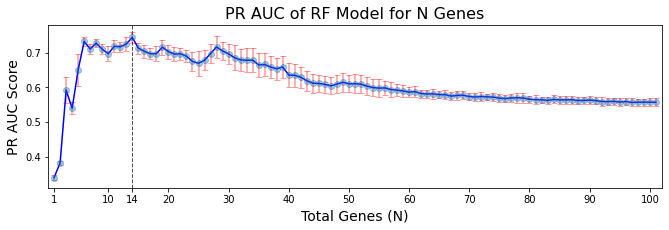

In [195]:
plt.figure(figsize=(11, 3))
plt.axvline(14, ls='--', alpha=0.7, lw=1, c='black')
plt.errorbar(
    x = range(1, 102),
    y = score_arr_gene.mean(1), yerr=score_arr_gene.std(axis=1, ddof=1),
    fmt='o', ecolor='red', alpha=0.4, capsize=3
)
plt.plot(range(1, 102), score_arr_gene.mean(1), c='blue')
plt.xlabel('Total Genes (N)', fontsize=14)
plt.ylabel('PR AUC Score', fontsize=14)
plt.xlim(0, 102)
plt.xticks(sorted([1]+list(range(10, 101, 10))+[14]))
plt.title("PR AUC of RF Model for N Genes", fontsize=16)

In [175]:
np.where(score_arr_gene.mean(1) > score_arr_gene.mean(1).max() - score_arr_gene.var(axis=1, ddof=1))

(array([13]),)

In [144]:
rt.writeln( gene_names[indices[:14]] )

YIPF2
PUF60
RBM10
HMG20B
SYMPK
HRAS
SMPD1
DDX41
ZNF444
SYBU
NUMA1
GPAA1
CLTB
TXNRD1


In [160]:
score_oob = evaluateRFOOB(
    X, y, feature_index=indices[:14],
    params=final_param,
    n_jobs=-1, use_proba=False, metric=f1_score, cv=400, seed=13420, verbose=1
)
print()
print(score_oob.mean(), score_oob.var(ddof=1))

Iteration - 399
0.5842670644572818 0.00038623924536467636


In [163]:
rt.evaluateLOO(X, y, indices[:14], rf_boruta, use_proba=False, metric=f1_score)

0.5833333333333334

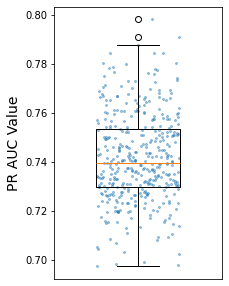

In [152]:
plt.figure(figsize=(3, 5))
plt.boxplot(score_oob, widths=0.5)
plt.scatter(np.random.uniform(0.75, 1.25, size=400), score_oob, s=4, alpha=0.4)
plt.xticks([])
plt.ylabel('PR AUC Value', fontsize=14)
plt.show()

# Gene Importance

In [115]:
rf_model_final = RandomForestClassifier(
    **final_param,
    n_jobs=4,
    random_state=345069
)

In [121]:
n_boot = 1000
rnd = np.random.default_rng(37335)
coef_arr = []
score_arr = []

for i in range(n_boot):
    X_boot, X_oob, y_boot, y_oob = rt.bootstrap_resample(X[:, indices[:14]], y, rnd_engine=rnd)

    rf_model_final.fit(X_boot, y_boot)
    coef_arr.append(rf_model_final.feature_importances_)
    rt.iterLog(i)

    # y_oob_pred_proba = model.predict_proba(X_oob_std)[:, 1]
    score_arr.append(
        rt.pr_auc(y_oob, rf_model_final.predict_proba(X_oob)[:, 1])
    )

coef_arr = np.array(coef_arr)
score_arr = np.array(score_arr)
print()
print(score_arr.mean(), score_arr.var(ddof=1))
# score_arr

Iteration - 999
0.7790093615513961 0.01954677182532269


In [118]:
import seaborn as sns

/var/folders/fj/p5kbwjtn3jng5py2h7l_1_mh0000gn/T/ipykernel_1820/3840079760.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gene_importance_sorted.values, y=gene_importance_sorted.index, palette='Set2')


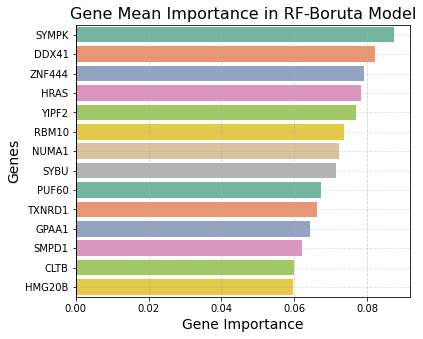

In [ ]:
gene_importance = pd.Series(
    coef_arr.mean(0),
    index=gene_names[indices[:14]]
)
gene_importance_sorted = gene_importance.reindex(gene_importance.abs().sort_values(ascending=False).index)
# colors = ['Protective' if val < 0 else 'Risk' for val in gene_importance_sorted]


plt.figure(figsize=(6, 5))
sns.barplot(x=gene_importance_sorted.values, y=gene_importance_sorted.index, palette='Set2')
plt.grid(axis="y", linestyle="--", alpha=0.4)


plt.xlabel("Gene Importance", fontsize=14)
plt.ylabel("Genes", fontsize=14)
plt.title("Gene Mean Importance in RF-Boruta Model", fontsize=16)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.6)


plt.show()
